![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## **MASTER DATA SCIENCE:** Nuclio
## **PROFESORES:** Valentina Borgonovi, Isidre Royo
## **ENTREGABLE 4:** Deep Learning - Visión por computador
## **ALUMNO:** Simone Solieri


## **Proyecto 12** - Resumen

Objetivo: Obtner un modelo con almenos el 90% de accuracy

Implementaciones:
Transfer learning con VGG-16 + Data augmentation. Uso solamente los primeros 3 bloques de cnvoluciones de VGG-16, que son los que sacan las features más generales.


**Resultados:**







## 1. Librerias & Google Drive

Para empezar carguemos esas librerias que nos hacen falta

In [ ]:
from tensorflow import keras as ks
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.regularizers import l2

from keras.applications import vgg16
from keras.models import Model, load_model

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime
import random

Incorporamos la carpeta de Google Drive para poder "guardar" nuestros modelos

1. Abrir barra lateral de Carpeta
2.  Hacer click en carpeta con logo de Google Drive


In [ ]:
# Aquí iria el codigo para conectarse a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Arquitectura de red del modelo


In [ ]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
output = vgg.get_layer('block3_pool').output
new_output_layer = ks.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(output)
vgg_model = Model(vgg.input, new_output_layer)

In [ ]:
vgg_model.trainable

True

In [ ]:
entrenable = False

for layer in vgg_model.layers:
  if layer.name == 'block3_conv1':
    entrenable = True
  layer.trainable = entrenable

In [ ]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.src.engine.input_layer.InputLayer object at 0x7da15c11a920>,input_1,False
1,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7da0c8c3e2c0>,block1_conv1,False
2,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7da0c8c3ea40>,block1_conv2,False
3,<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7da0c8c3e620>,block1_pool,False
4,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7da0c8c3ec50>,block2_conv1,False
5,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7da0c8c3f7f0>,block2_conv2,False
6,<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7da0c8391570>,block2_pool,False
7,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7da0c8391de0>,block3_conv1,True
8,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7da0c8392500>,block3_conv2,True
9,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7da0c8393010>,block3_conv3,True


In [ ]:
model = ks.Sequential()

model.add(vgg_model)
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(1024, activation='relu'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Dense(1024, activation='relu'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Dense(10, activation='softmax'))


Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 4, 4, 512)         2915648   
                                                                 
 batch_normalization (Batch  (None, 4, 4, 512)         2048      
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 512)         2359808   
                                                                 
 batch_normalization_1 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 4, 4, 512)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0

## 3. Optimizador, función error


In [ ]:
model.compile(optimizer= Adam(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 4. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:**
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 32x32 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [ ]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

170498071/170498071 [==============================] - 13s 0us/step


In [ ]:
print("Etiquetas de train:", y_train)


# Convertir los datos en arrays de una dimension (vectores) es una buena mejora en el dataset
y_train = y_train.ravel()
y_test = y_test.ravel()


print("Etiquetas de train (en vector):", y_train)


Etiquetas de train: [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
Etiquetas de train (en vector): [6 9 9 ... 9 1 1]


Obtenemos un array con todas las labels de CIFAR10

In [ ]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000,)
Test: X=(10000, 32, 32, 3), y=(10000,)


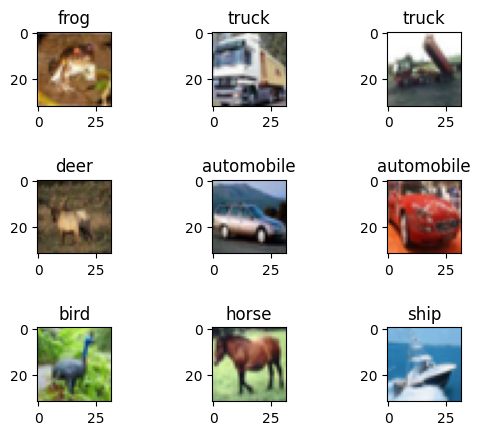

In [ ]:
# Pintemos una muestra de las las imagenes del dataset Cifar10

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [ ]:
x_val_scaled = x_train_scaled[-10000:]
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train_scaled = x_train_scaled[:-10000]
x_train = x_train[:-10000]
y_train = y_train[:-10000]


Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución espera una matriz de 4 campos** (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [ ]:
# Validamos el resultado
print('Train_scaled: X=%s, y=%s' % (x_train_scaled.shape, y_train.shape))
print('Test_scaled: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))
print('Validation_scaled: X=%s, y=%s\n' % (x_val_scaled.shape, y_val.shape))

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))

Train_scaled: X=(40000, 32, 32, 3), y=(40000,)
Test_scaled: X=(10000, 32, 32, 3), y=(10000,)
Validation_scaled: X=(10000, 32, 32, 3), y=(10000,)

Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)
Validation: X=(10000, 32, 32, 3), y=(10000,)


## 5. Exploremos los datos

<Axes: xlabel='category'>

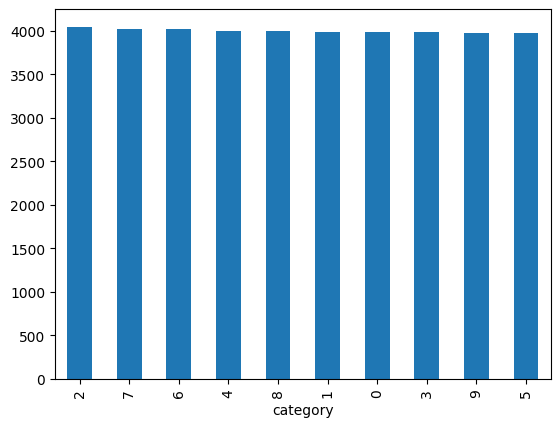

In [ ]:
df_train = pd.DataFrame(y_train, columns=['category'])
df_train['category'].value_counts().plot.bar()

Hay 4000 imagenes para cada categoria.

## 6. Montamos el generador de imagenes

**De entrenamiento**

Aquí incluiremos nuestra parte de generación de imagenes (con código de partida)

In [ ]:
batch_size_train = 512

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    height_shift_range=0.1,
    width_shift_range=0.1,
    fill_mode='nearest',
    # Definamos las transformaciones
    )

train_generator = train_datagen.flow(
    x_train,  # Aquí hay que usar datos NO re-escalados... de ahi que no usemos x_train_rescaled!
    y_train,
    batch_size=batch_size_train
)

In [ ]:
40000//512

78

In [ ]:
512/4

128.0

**De validacion (test no lo necesita)**

Fijaos que aquí la única modificación es un re-escalado, nada de modificaciones

In [ ]:
batch_size_val = 128

In [ ]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val,
    y_val,
    batch_size=batch_size_val
)


## 7. Veamos que pinta tiene el generador de datos

A rellenar para ver que nos da el generador de imagenes nuevas

In [ ]:
sample = random.choice(range(0,1457))

example_generator = train_datagen.flow(
    x_train[sample:sample+1],
    y_train[sample:sample+1],
    batch_size=20
    )

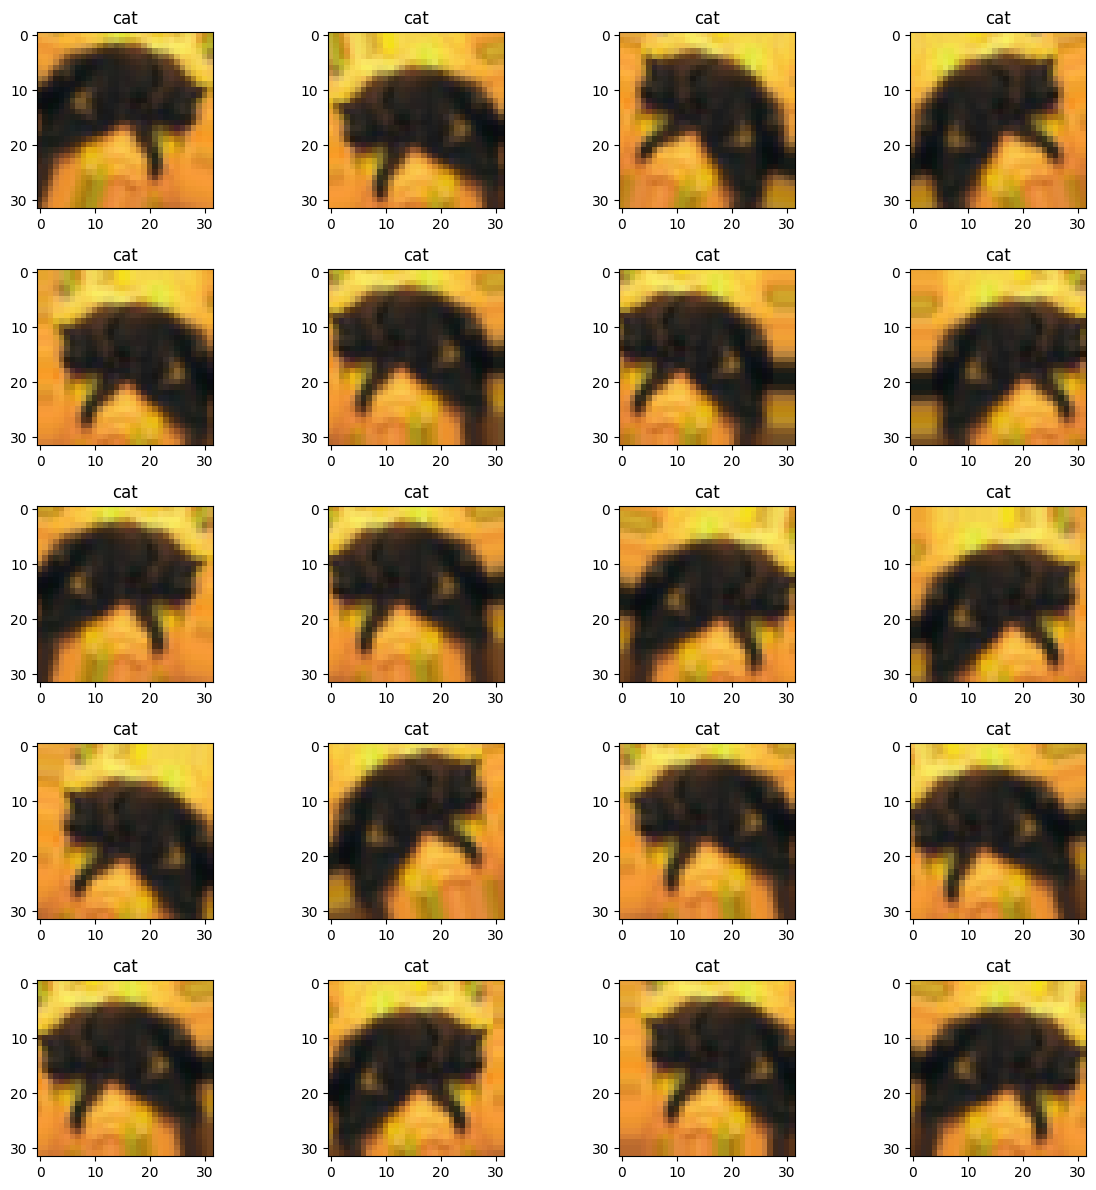

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 20):
    plt.subplot(5, 4, i+1)
    for X, Y in example_generator:
        image = X[0]
        plt.imshow(image)
        plt.title(cifar10_labels[Y[0]])
        break
plt.tight_layout()
plt.show()

## 8. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 512

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [ ]:
t = time.perf_counter()

In [ ]:
# # EarlyStopping
earlystop_val_acc = EarlyStopping(monitor= 'val_accuracy', patience=30)
earlystop_val_loss = EarlyStopping(monitor='val_loss', patience=30)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=20, min_lr=1e-5, )

# ModelCheckpoint
checkpoint_path = '/content/drive/MyDrive/Master_Data_Science/Entregables/Entregable_04-Deep_Learning/Models/Model_Checkpoints/Best_accuracy_proyecto_12'
modelcheckpoint_best_acc = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True)

In [ ]:
history = model.fit(
        train_generator,
        steps_per_epoch= 40000 // batch_size_train,
        epochs=200,
        validation_data=validation_generator,
        validation_steps=10000 // batch_size_val,
        callbacks=[modelcheckpoint_best_acc, reduce_lr_callback, earlystop_val_loss, earlystop_val_acc ])

Epoch 1/200
78/78 [==============================] - 50s 430ms/step - loss: 2.3734 - accuracy: 0.1920 - val_loss: 87.5284 - val_accuracy: 0.1013 - lr: 0.0100
Epoch 2/200
78/78 [==============================] - 29s 371ms/step - loss: 1.9231 - accuracy: 0.2722 - val_loss: 3.8600 - val_accuracy: 0.1252 - lr: 0.0100
Epoch 3/200
78/78 [==============================] - 26s 328ms/step - loss: 1.7176 - accuracy: 0.3507 - val_loss: 41.3411 - val_accuracy: 0.0998 - lr: 0.0100
Epoch 4/200
78/78 [==============================] - 30s 381ms/step - loss: 1.5548 - accuracy: 0.4105 - val_loss: 7.7367 - val_accuracy: 0.1432 - lr: 0.0100
Epoch 5/200
78/78 [==============================] - 30s 388ms/step - loss: 1.4745 - accuracy: 0.4494 - val_loss: 5.9210 - val_accuracy: 0.1876 - lr: 0.0100
Epoch 6/200
78/78 [==============================] - 26s 329ms/step - loss: 1.3170 - accuracy: 0.5116 - val_loss: 5.2040 - val_accuracy: 0.1495 - lr: 0.0100
Epoch 7/200
78/78 [==============================] - 29s

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 1:18:50.708430


Cargo el mejor model que he guardado con el ModelCheckpoint.


In [ ]:
model = ks.models.load_model(checkpoint_path)

## 9. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [ ]:
_, acc = model.evaluate(x_test_scaled, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 85.910


In [ ]:
# elimino el primer valor de val_loss para no distorsionar el grafico de loss, en cuanto el error a la prima iteración es muy alto
# comparado con los demás.
first_val_loss = history.history['val_loss'].pop(0)

In [ ]:
first_val_loss

87.52840423583984

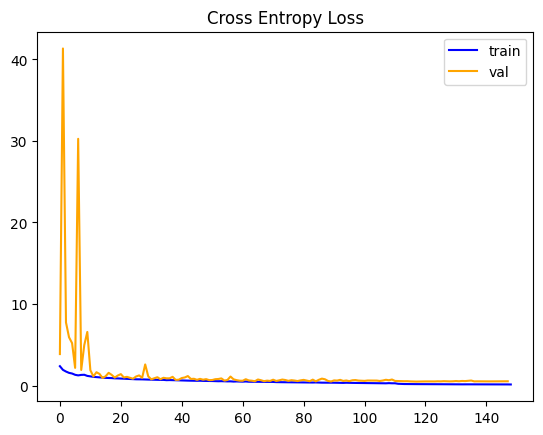

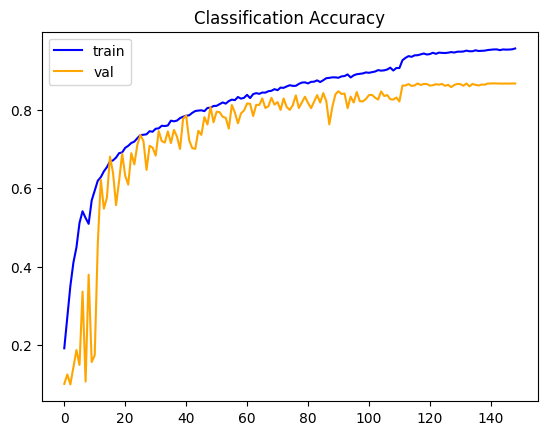

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [ ]:
predictions = model.predict(x_test)

313/313 [==============================] - 2s 6ms/step


Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


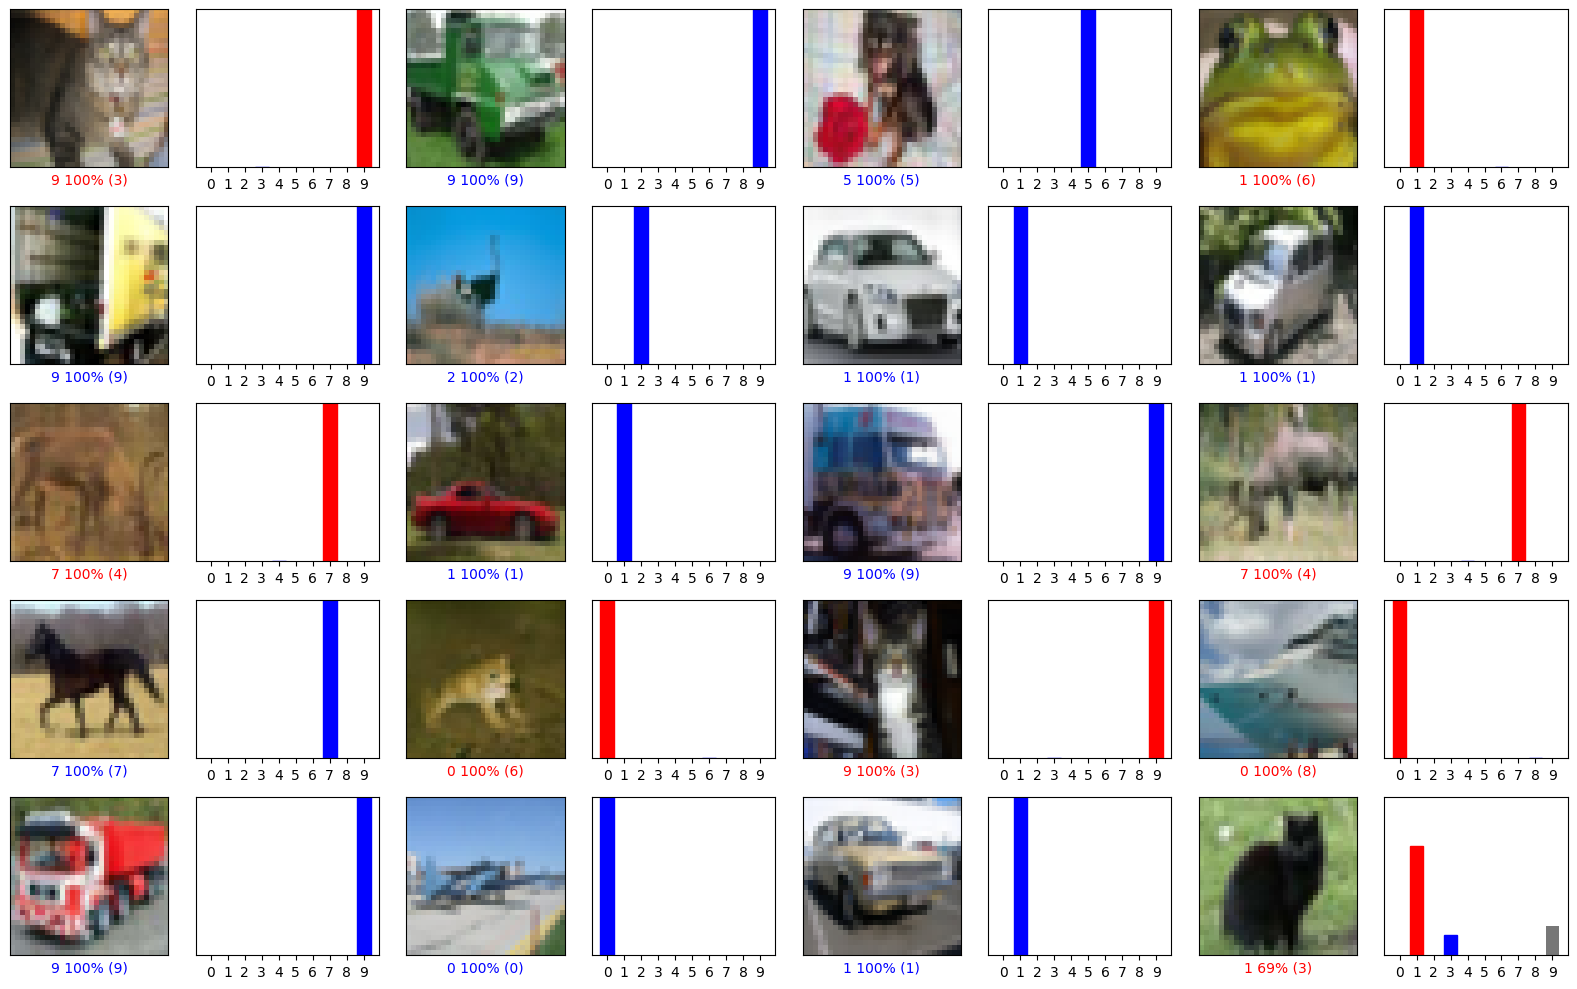

In [ ]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 10. Guardamos el modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [ ]:
ruta_googledrive = "/content/drive/MyDrive/Entregables/Entregable_04-Deep_Learning/Models/" # A revisar en vuestra instancia

model.save(ruta_googledrive+'cifar10_model_12.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
